# DD2434_Project

# Setup

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy
from scipy import special, misc
from scipy.special import logsumexp
from scipy.special import digamma, gammaln, polygamma
import pandas as pd
from collections import Counter 

## Load the Document Corpus
Download the data from 
https://github.com/Blei-Lab/lda-c/blob/master/example/ap.tgz

We can directly load the file "ap.dat" which contains:

1 line = 1 document,

[number of different words in doc] [word index (where the one is in w_n]:[how often it occurs in the doc] [word index 2]:[occurences 2] ...

In [2]:
vocabulary = np.genfromtxt('ap/vocab.txt',  dtype='str')

In [3]:
def clean_up_data(corpus_file, vocabulary_file, stopwords_file):
    """
    Reads the corpus from the .txt file into a list of lists;
    a list for each document which contains a list of all the 
    words as strings.
    Input parameters:
    corpus_file - path to the corpus file
    vocabulary_file - path to the vocabulary file
    stopwords_file - path to the stopwords file
    """
    vocabulary = np.genfromtxt(vocabulary_file,  dtype='str')
    special_chars = '1234567890~!@#£$%^&*()_+,./<>?\|"]}\'[{`-'
    corpus = []
    
    # read in stopwords from file into a list
    stopwords = [] 
    with open(stopwords_file, 'r') as file:
        stop_words = file.read().replace(',', ' ')
        for word in stop_words.split():
            stopwords.append(word) 
    
    with open(corpus_file, 'r') as text:
        doc = ''
        new = False
        for line in text:
            if new: # reached a new document
                if line.strip() != '</TEXT>': # until we reach the new doc
                    for char in special_chars: # remove punctuation etc,
                        line = line.replace(char, '') 
                    doc += line
                else: # we've reached a new doc again
                    doc = doc.lower() # all words lowercase
                    words = np.array(doc.split())
                    # PETER EDIT: next two lines
                    doc = [word for word in words if (  (word not in stopwords) and (word in vocabulary)  )]
                    corpus.append(doc)
                    doc = ''
            elif line.strip() == '<TEXT>': new = True

    
    return corpus, vocabulary

In [4]:
corpus, vocabulary = clean_up_data('ap/ap.txt', 'ap/vocab.txt', 'ap/stopwords.txt')

In [5]:
def initialize_parameters(documents, vocabulary, k):
    M = len(documents)
    V = len(vocabulary)
    
    # Initialize alpha 
    # alpha = np.ones([M,k]) * 50/k # for every document, for every topic
    alpha = np.ones(k)*50/k
    eta = 5/k
    
    Lambda = np.random.rand(k,V) * 0.5 + 0.5
    
    # Initialize beta
    beta = np.zeros([k,V]) # for every topic, for every word in the vocabulary
    for i in range(k):
        beta[i] = np.random.uniform(0, 1, V)
        beta[i] = beta[i] / np.sum(beta[i])
    
    # Initialize phi and gamma
    phi = []
    gamma = np.zeros([M,k]) # for every document, for every topic
    for m in range(M):
        doc = np.array(documents[m])
        N = len(doc)
        phi.append(np.ones([N,k]) * 1/float(k)) # uniform over topics
        
        for i in range(k):
            gamma[m][i] = alpha[i] + N/float(k)
        #m += 1 # WHYYYYYYY?
        
    return alpha, eta, beta, gamma, phi, Lambda

In [6]:
def compute_lower_bound_likelihood(phi, gamma, alpha, beta, document, vocabulary, k):
    '''
    This calculates the lower bound of L(gamma, phi, alpha, beta)
    Ie. equation 15 in the paper in Appendix 3.
    '''
   
    N, k = phi.shape
    k, V = beta.shape
    
    loggamma_sum = lambda x: scipy.special.gammaln(np.sum(x))
    loggamma_x_i = lambda x, i: np.log(scipy.special.gamma(x[i]))
    E_log_thetai_givenGamma = lambda i:  (psi(gamma[i]) - psi(np.sum(gamma))) 

    term0 = loggamma_sum(alpha) - loggamma_sum(gamma)
    term_kSum=0
    for i in range(k):
        E = E_log_thetai_givenGamma(i)
        term_kSum += -loggamma_x_i(alpha,i) + (alpha[i]-1) * E
        term_kSum += gammaln(gamma[i]) - (gamma[i] - 1) * E

        term_knSum = 0
        term_knvSum = 0
        for n in range(N):
            if phi[n,i] == 0:
                print("Error: Phi[",n,i,"] == 0")
            term_knSum += phi[n,i] * E_log_thetai_givenGamma(i)
            term_knSum += - phi[n,i] * np.log(phi[n,i])
            
            v = np.where(vocabulary == document[n])[0][0] # here w_n is not a vector
            if beta[i,v] <= 0:
                print("Error: beta["+i,v,"]<=0")
            #L+= phi[n,i] * np.log(beta[i,v]) 
            term_knvSum += phi[n,i] * np.log(beta[i,v]) 

    #print(term0,term_knSum, term_kSum)
    L_terms = term0 + term_knSum + term_kSum + term_knvSum
    
    return L_terms
    


def psi(gamma_i):
    # this is the first derivative (via Taylor approximation) of the log \Gamma function
    # according to Wikipedia this is the "digamma" function
    return scipy.special.digamma(gamma_i)



In [7]:
def compute_lower_bound_likelihood_smoothed(phi, gamma, alpha, Lambda, document, vocabulary, digamma_lambda, k, V):
    '''
    This calculates the lower bound of L(gamma, phi, alpha, beta)
    Ie. equation 15 in the paper in Appendix 3.
    '''
   
    N, k = phi.shape
    
    loggamma_sum = lambda x: scipy.special.gammaln(np.sum(x))
    loggamma_x_i = lambda x, i: np.log(scipy.special.gamma(x[i]))
    E_log_thetai_givenGamma = lambda i:  (psi(gamma[i]) - psi(np.sum(gamma))) 
    #E_log_betai_givenLambda = lambda i:  (psi(Lambda[i].T) - psi(np.sum(Lambda))) 

    term0 = loggamma_sum(alpha) - loggamma_sum(gamma)
    term_kSum=0
    for i in range(k):
        E = E_log_thetai_givenGamma(i)
        term_kSum += -loggamma_x_i(alpha,i) + (alpha[i]-1) * E
        term_kSum += gammaln(gamma[i]) - (gamma[i] - 1) * E

        term_knSum = 0
        for n in range(N):
            if phi[n,i] == 0:
                print("Error: Phi[",n,i,"] == 0")
                
            term_knSum += phi[n,i] * E_log_thetai_givenGamma(i)
            term_knSum += - phi[n,i] * np.log(phi[n,i])
            term_knSum += phi[n,i] * digamma_lambda[i]

    
    L_terms = term0 + term_knSum + term_kSum 
    
    return L_terms

In [8]:
def update_phi_gamma(k, phi, gamma, alpha, beta, document, vocabulary, tol=1e-5, MAX_STEPS = 100):
    
    likelihood = 0.0
    iterations = 0
    converged = False
    
    words = np.array(document)
    N = len(words)

    while (not converged) and (iterations < MAX_STEPS):
        iterations += 1
            
        phi_old = phi.copy()
        gamma_old = gamma.copy()

        for n in range(N):
            word = words[n]
            if len(np.where(vocabulary == word)[0]) > 0: # word exists in vocabulary
                for i in range(k):                
                    beta_ = beta[i, np.where(vocabulary == word)]
                    phi[n, i] = beta_[0][0] * np.exp(digamma(gamma[i]) - digamma(np.sum(gamma)))
                phi[n,:] = phi[n,:] / np.sum(phi[n,:])   
        
        
        gamma = alpha + np.sum(phi, axis=0)
        
        

        # Convergence ctierion: did phi and gamma change significantly?
        if (np.linalg.norm(phi - phi_old) < tol) and (np.linalg.norm(gamma - gamma_old) < tol):              
            print(str(iterations) + ' iterations to converge.')
                
            likelihood += compute_lower_bound_likelihood(phi, gamma, alpha, beta, document, vocabulary, k)
            converged = True
    
    return phi, gamma, likelihood

In [9]:
def update_phi_gamma_smoothed(k, M, V, phi, gamma, alpha, eta, Lambda, documents, vocabulary, document, tol=1e-5, MAX_STEPS = 100):
    
    digamma_lambda = digamma(Lambda.T) - digamma(np.sum(Lambda, axis = 1))
    
    for d in range(M):
        likelihood = -0.00001
        iterations = 0
        converged = False
        
        words = np.array(documents[d])
        N = len(words)

        while (not converged) and (iterations < MAX_STEPS):
            iterations += 1
            
            phi_old = phi[d].copy()
            gamma_old = gamma[d].copy()

            digamma_gamma = digamma(gamma[d,:]) - digamma(np.sum(gamma[d,:]))
            N = len(documents[d])
            
            for n in range(N):
                word = words[n]
                if len(np.where(vocabulary == word)[0]) > 0: # word exists in vocabulary
                    for i in range(k):
                        temp_2 = digamma_gamma[i] + digamma_lambda[d][i]
                        phi[d][n, i] = np.exp(temp_2)
                    phi[d][n,:] =  phi[d][n,:] / np.sum(phi[d][n,:] + tol)
            
            gamma[d] = alpha + np.sum(phi[d], axis=0) 
            

            # Convergence ctierion: did phi and gamma change significantly?            
            if (np.linalg.norm(phi[d] - phi_old) < tol) and (np.linalg.norm(gamma[d] - gamma_old) < tol):              
                print(str(iterations) + ' iterations to converge.')

                likelihood += compute_lower_bound_likelihood_smoothed(phi[d], gamma[d], alpha, Lambda, document, vocabulary, digamma_lambda[d], k, V)
                converged = True

    return phi, gamma, likelihood

In [10]:
def update_lambda(phi, eta, Lambda, documents, vocabulary, k):
    
    M = len(documents)
    V = len(vocabulary)
    
    Lambda = np.ones([k, V]) * eta
    for m, doc in enumerate(documents):
        words = np.array(doc)
        phi_m = phi[m]
        for i in range(k):
            phi_ = phi_m[:,i]
            for j in range(V):
                word = vocabulary[j]
                indicator = np.in1d(words, word)
                indicator.astype(int) 
                Lambda[i][j] += np.dot(indicator, phi_)

    return Lambda

In [11]:
def update_beta(phi, documents, vocabulary, k):
    
    M = len(documents)
    V = len(vocabulary)
    
    beta = np.zeros([k, V])
    for m, doc in enumerate(documents):
        words = np.array(doc)
        phi_m = phi[m]
        for i in range(k):
            phi_ = phi_m[:,i]
            for j in range(V):
                word = vocabulary[j]
                indicator = np.in1d(words, word)
                indicator.astype(int) 
                beta[i][j] += np.dot(indicator, phi_)
    beta = np.transpose(np.transpose(beta) / np.sum(beta, axis=1))

    return beta
    

In [12]:
def update_alpha(alpha, gamma, k, M, max_iter=50, tol=1e-4):
    
    # Maria B version
    temp = 0
    for d in range(M):
        temp_1 = np.sum(special.polygamma(0, gamma[d])) - np.sum(special.polygamma(0, np.sum(gamma, axis=1)))
    
    gradient = M * (k * special.polygamma(1, alpha) - special.polygamma(1, k*alpha))
    gradient = gradient + temp

    hessian = M * k * (k * special.polygamma(2, k*alpha) - special.polygamma(2, alpha))

    temp = gradient / (hessian * alpha + gradient + tol)
    if (alpha == 0).any():
        alpha += 0.005

    log_alpha = np.log(alpha) - temp
    alpha = np.exp(log_alpha)    
        
    return alpha


In [13]:
def update_eta(eta, gamma, k, V, M, max_iter=50, tol=1e-4):

    temp = 0
    for d in range(M):
        temp_1 = np.sum(special.polygamma(0, gamma[d])) - np.sum(special.polygamma(0, np.sum(gamma, axis=1)))
    
    gradient = V * (k * special.polygamma(1, eta) - special.polygamma(1, k*eta))
    gradient = gradient + temp

    hessian = V * k * (k * special.polygamma(2, k*eta) - special.polygamma(2, eta))

    temp = gradient / (hessian * eta + gradient + tol)
    if (eta == 0):
        eta += 0.005

    log_eta = np.log(eta) - temp
    eta = np.exp(log_eta)    
        
    return eta

In [14]:
def E_step(phi, gamma, alpha, beta, documents, vocabulary, k):
    print('E-step')
    
    for d, doc in enumerate(documents):
        phi[d], gamma[d], likelihood = update_phi_gamma(k, phi[d], gamma[d], alpha, beta, doc, vocabulary)
                
    return phi, gamma, likelihood

In [15]:
def E_step_smoothed(phi, gamma, alpha, eta, Lambda, documents, vocabulary, k):
    print('E-step')
    
    V = len(vocabulary)

    phi, gamma, likelihood = update_phi_gamma_smoothed(k, M, V, phi, gamma, alpha, eta, Lambda, documents, vocabulary, Lambda)
    Lambda = update_lambda(phi, eta, Lambda, documents, vocabulary, k)
        
    return phi, gamma, Lambda, likelihood

In [16]:
def M_step(phi, gamma, alpha, documents, vocabulary, k):
    print('M-step')
    
    M = len(documents)
    V = len(vocabulary)
    
    beta = update_beta(phi, documents, vocabulary, k)
    alpha = update_alpha(alpha, gamma, k, M)
    
    return alpha, beta

In [17]:
def M_step_smoothed(phi, gamma, alpha, eta, documents, vocabulary, k):
    print('M-step')
    
    M = len(documents)
    V = len(vocabulary)

    alpha = update_alpha(alpha, gamma, k, M)
    eta = update_eta(eta, gamma, k, V, M)

    return alpha, eta

In [18]:
def variational_EM(phi_init, gamma_init, alpha_init, beta_init, documents, vocabulary, k, tol=1e-5):
    print('Variational EM')
    
    M = len(documents)
    
    likelihood = 0
    likelihood_old = 0.000004
    
    iteration = 1 # Initialization step is the first step
    
    phi = phi_init
    gamma = gamma_init
    alpha = alpha_init
    beta = beta_init
    
    converged = False
    
    while (not converged):
        
        iteration += 1
        
        # Update parameters 
        if likelihood == 0:
            print("Likelihood==0")
            likelihood_old = 0.005
        else:
            likelihood_old = likelihood
        phi_old = phi 
        gamma_old = gamma 
        alpha_old = alpha
        beta_old = beta
    
        phi, gamma, likelihood = \
            E_step(phi_old, gamma_old, alpha_old, beta_old, documents, vocabulary, k)
        alpha, Beta = \
            M_step(phi, gamma, alpha_old, documents, vocabulary, k)
                
        if iteration > 15:
            break
        
        # check convergence
        if (np.abs((likelihood-likelihood_old)/likelihood_old) > tol):
            if (iteration > 2):
                converged = True
        
    return phi, gamma, alpha, Beta, likelihood

In [19]:
def variational_EM_smoothed(phi_init, gamma_init, alpha_init, beta_init, Lambda_init, eta_init, documents, vocabulary, k, tol=1e-5):
    print('Variational EM')
    
    M = len(documents)
    
    likelihood = 0
    likelihood_old = 0.000004
    
    iteration = 1 # Initialization step is the first step
    
    phi = phi_init
    gamma = gamma_init
    alpha = alpha_init
    beta = beta_init
    Lambda = Lambda_init
    eta = eta_init
    
    converged = False
    
    while (not converged):
        
        iteration += 1
        
        # Update parameters 
        if likelihood == 0:
            print("Likelihood==0")
            likelihood_old = 0.005
        else:
            likelihood_old = likelihood
        phi_old = phi 
        gamma_old = gamma 
        alpha_old = alpha
        beta_old = beta
        Lambda_old = Lambda
        eta_old = eta
        
    
        phi, gamma, Lambda, likelihood = \
            E_step_smoothed( phi_old, gamma_old, alpha_old, eta_old, Lambda_old, documents, vocabulary, k)
        alpha, eta = \
            M_step_smoothed(phi, gamma, alpha, eta, documents, vocabulary, k)
                
        if iteration > 15:
            break
            
        # check convergence
        if (np.abs((likelihood - likelihood_old) / likelihood_old) > tol):
            if (iteration > 2):
                converged = True
        
    return phi, gamma, Lambda, alpha, eta, likelihood

# MAIN: LDA

In [20]:
k = 3
corpus_reduced = corpus[:4]
M = len(corpus_reduced)


In [21]:
alpha_init, eta_init, beta_init, gamma_init, phi_init, Lambda_init = initialize_parameters(corpus_reduced, vocabulary, k)

In [22]:
phi, gamma, alpha, beta, likelihood = \
        variational_EM(phi_init, gamma_init, alpha_init, beta_init, corpus_reduced, vocabulary, k)

Variational EM
Likelihood==0
E-step
43 iterations to converge.
46 iterations to converge.
42 iterations to converge.
39 iterations to converge.
M-step
E-step
49 iterations to converge.
55 iterations to converge.
48 iterations to converge.
45 iterations to converge.
M-step


# MAIN: smoothed LDA

In [23]:
alpha_init, eta_init, beta_init, gamma_init, phi_init, Lambda_init = initialize_parameters(corpus_reduced, vocabulary, k)

In [24]:
phi, gamma, Lambda, alpha, eta, likelihood = \
variational_EM_smoothed(phi_init, gamma_init, alpha_init, beta_init, Lambda_init, eta_init, corpus_reduced, vocabulary, k, tol=1e-5)

Variational EM
Likelihood==0
E-step
29 iterations to converge.
62 iterations to converge.
43 iterations to converge.
49 iterations to converge.
M-step
E-step
100 iterations to converge.
91 iterations to converge.
74 iterations to converge.
88 iterations to converge.
M-step


# Analysis

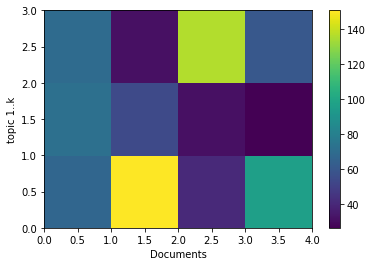

In [26]:
plt.pcolormesh(gamma.T)
plt.xlabel("Documents")
plt.ylabel("topic 1..k")
plt.colorbar()

In [27]:
#plt.pcolormesh(Beta)

['museum', 'teacher', 'school', 'police', 'shot']
['man', 'police', 'museum', 'offer', 'mrs']
['bloomberg', 'students', 'years', 'police', 'peres']


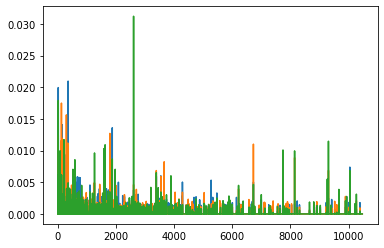

In [28]:
for l in range(k):
    beta_topic = beta[l,:]
    beta_topic_top4 = np.argsort(beta_topic)[-5:]
    plt.plot(beta_topic)
    print([w for w in np.array(vocabulary)[beta_topic_top4][:]])

## WRITE TEXT WITH COLOR

In [29]:
def get_full_text(corpus_file, number_of_text):
    fulltext_words=[]
    fulltext_allwords=[]
    #number_of_text=2
    text_counter=0
    special_chars = '1234567890~!@#£$%^&*()_+,./<>?\|"]}\'[{`-'

    with open(corpus_file, 'r') as text:
        new=False
        for line in text:
            if new:
                #print(line.strip()[0], line.strip()[:10])
                if line.strip()[0]=="<":
                    pass
                else:
                    #print("FOUND", text)
                    text_counter+=1
                    if text_counter==number_of_text:
                        #print(" CORRECT")
                        new_text=line
                        fulltext=new_text
                        words = np.array(new_text.split())
                        for word in words:
                            fulltext_allwords.append(word)
                            for char in special_chars: # remove punctuation etc,
                                word = word.replace(char, '') 
                            fulltext_words.append(word)


            else:
                if line.strip() == "<TEXT>":
                    new=True
    return fulltext_words, fulltext_allwords

fulltext_words, fulltext_allwords = get_full_text('ap/ap.txt', 13)
" ".join(fulltext_words[:100])

'For three years Charles S Robb was out of the spotlight that had become so familiar first as the soninlaw of President Lyndon Johnson and then as Democratic governor of this conservative state But on Tuesday the yearold lawyer reentered the national arena in decisive style fashioning a huge victory over Republican longshot Maurice Dawkins a retired black minister and Washington lobbyist Robb said today he won because we attempted to identify with mainstream values that are crucial to success at the national level such as strong defense and fiscal responsibility With  percent of the precincts counted Robb had'

In [30]:
colors=['blue','green', 'red']
fulltext_colors=[]

how_significant=2.5
significance=[]
for word in fulltext_words:
    if word in vocabulary:
        v = np.where(vocabulary==word)[0][0]
        #print(v,word_beta )
        word_beta = beta[:,v]
        #significance.append(np.max(word_beta)/np.mean(word_beta))
        if np.max(word_beta)>np.mean(beta):
            if np.max(word_beta)> how_significant*np.mean(word_beta):
                #significance =  (np.max(word_beta) / np.mean(word_beta) > 10)
                topic = np.where(np.max(word_beta)==word_beta)[0][0]
                color = colors[topic]
                print(word+"=",str( topic)+", ", end="")

            else:
                color='k'
        else:
            color='k'
    else: 
        color='k'
    fulltext_colors.append(color)

In [31]:
#http://ozzmaker.com/add-colour-to-text-in-python/
#print("Examples of how to use ANSI COLOR: \033[1;37;40m White          \033[0m 1;37;40m            \033[0;37;40m Light Grey \033[0m 0;37;40m               \033[0;37;48m Black      \033[0m 0;37;48m")
colors_ansi=[34, 32,31] #blue, green, red
             
             
for a in range(len(fulltext_allwords)):
    if fulltext_colors[a]=='k':
        #IF WE WANT TO FOCUS ON THE TOPIC WORDS:
        #print("\033[0;37;48m"+fulltext_allwords[a], end=" ")
        print("\033[0m"+fulltext_allwords[a], end=" ")
        
        #print(fulltext_allwords[a], end=" ")
    else:
        for j in range(k):
             if fulltext_colors[a]==colors[j]:
                print("\033[0;"+str(colors_ansi[j])+";48m"+fulltext_allwords[a], end=" ")

For three years, Charles S. Robb was out of the spotlight that had become so familiar, first as the son-in-law of President Lyndon Johnson and then as Democratic governor of this conservative state. But on Tuesday, the 49-year-old lawyer re-entered the national arena in decisive style, fashioning a huge victory over Republican long-shot Maurice Dawkins, a retired black minister and Washington lobbyist. Robb said today he won because ``we attempted to identify with mainstream values that are crucial to success at the national level,'' such as strong defense and fiscal responsibility. With 99 percent of the precincts counted, Robb had 1,448,389 votes or 71 percent, to Dawkins' 587,887 votes or 29 percent. The former Marine combat officer has built a career by making Democrats electable in conservative Virginia. Once known only as the former White House military social aide who married LBJ's daughter, Lynda Bird Johnson, he won the lieutenant governor's race in 1977 in his first bid for e

In [32]:
topic_words =[]
for i in range(k):
    topic_words.append(np.where(np.array(fulltext_colors)==colors[i]))
    print("\033[0mTOPIC: "+str(i)+": "+"\033[0;"+str(colors_ansi[i])+";48m"+ ", ".join(np.array(fulltext_words)[topic_words[i]]))
    print("\033[0m")

TOPIC: 0: 

TOPIC: 1: 

TOPIC: 2: 



# REUTERS DATA (get from the external program to keep this a bit tidier)

In [33]:
from getReuters import D_reuters as corpus_reuters
from getReuters import vocab_list as vocabulary_reuters
vocabulary_reuters=np.array(vocabulary_reuters)

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\bjeli\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


M_max_reuters =  7769
We have  100  Documents with sizes:  [633, 259, 119, 155, 115, 34, 250, 83, 182, 133, 126, 85, 84, 111, 99, 101, 67, 26, 73, 140, 108, 173, 49, 236, 109, 111, 365, 42, 66, 49, 130, 90, 52, 21, 136, 14, 28, 102, 110, 67, 72, 143, 196, 31, 24, 34, 601, 32, 123, 958, 193, 118, 36, 55, 54, 113, 36, 67, 569, 25, 100, 185, 60, 145, 78, 61, 10, 87, 252, 61, 151, 466, 128, 44, 25, 179, 180, 54, 167, 42, 76, 114, 301, 506, 78, 83, 51, 111, 254, 10, 136, 186, 127, 145, 85, 34, 34, 91, 68, 77]


In [34]:
k_reuters = 2
corpus_reuters_reduced = corpus_reuters[:10]
M_reuters = len(corpus_reuters_reduced)


In [35]:


alpha_init_reuters, eta_init_reuters, beta_init_reuters, gamma_init_reuters, phi_init_reuters, Lambda_init_reuters =\
    initialize_parameters(corpus_reuters_reduced, vocabulary_reuters, k_reuters)

In [36]:
Phi_reuters, gamma_reuters, alpha_reuters, Beta_reuters, likelihood_reuters = \
        variational_EM(phi_init_reuters, gamma_init_reuters, alpha_init_reuters, beta_init_reuters, 
                       corpus_reuters_reduced, vocabulary_reuters, k_reuters)

Variational EM
Likelihood==0
E-step
34 iterations to converge.
23 iterations to converge.
15 iterations to converge.
21 iterations to converge.
17 iterations to converge.
11 iterations to converge.
25 iterations to converge.
15 iterations to converge.
20 iterations to converge.
19 iterations to converge.
M-step
E-step
35 iterations to converge.
26 iterations to converge.
17 iterations to converge.
26 iterations to converge.
21 iterations to converge.
13 iterations to converge.
29 iterations to converge.
19 iterations to converge.
24 iterations to converge.
22 iterations to converge.
M-step


# TODO Analysis for REUTERS

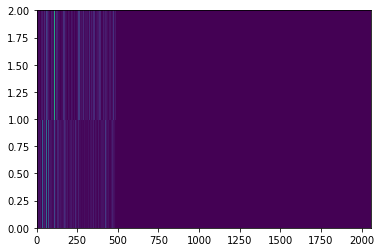

In [37]:
plt.pcolormesh(Beta_reuters)